In [ ]:
!pip install causalpfn xgboost econml
!pip install pandas scikit-learn

import pandas as pd
import numpy as np
import zipfile
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.50.0
    Uninstalling shap-0.50.0:
      Successfully uninstalled shap-0.50.0


In [ ]:
# Data Loading

df = pd.read_csv("/content/full_dataset.csv")

with zipfile.ZipFile("/content/features_dinov3_vitl16.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dino_features")

features_path = "/content/dino_features/features_dinov3_vitl16"

# Load DINO features
df_image_ids = set(df['Unnamed: 0'].values)
image_features_dict = {}

for f_name in os.listdir(features_path):
    if f_name.endswith('.pt'):
        try:
            image_id = int(f_name.split('.')[0])
            if image_id in df_image_ids:
                f_path = os.path.join(features_path, f_name)
                image_features_dict[image_id] = torch.load(f_path).numpy()
        except ValueError:
            print(f"Skipping non-numeric feature file: {f_name}")

# Align dataframe with available features
available_image_ids_in_dict = set(image_features_dict.keys())
df = df[df['Unnamed: 0'].isin(available_image_ids_in_dict)].sort_values(by='Unnamed: 0').reset_index(drop=True)

ordered_features = [image_features_dict[idx] for idx in df['Unnamed: 0']]
X_embed = np.stack(ordered_features)

print("DINO Features Shape:", X_embed.shape)

Skipping non-numeric feature file: temp.pt
DINO Features Shape: (6693, 1024)


In [ ]:
# Prepare Covariates and Outcomes

# Extract treatment and outcome
T = df["treatment"].values.astype(np.float32)
Y = df["outcome"].values.astype(np.float32)

# Extract additional covariates (exclude treatment, outcome, ID columns)
exclude_cols = ['treatment', 'outcome', 'Unnamed: 0']
if 'cate' in df.columns:
    exclude_cols.append('cate')  # Don't include true CATE as a feature

covariate_cols = [col for col in df.columns if col not in exclude_cols]
X_covariates = df[covariate_cols].values.astype(np.float32)

print(f"Additional Covariates Shape: {X_covariates.shape}")
print(f"Covariate columns: {covariate_cols}")


Additional Covariates Shape: (6693, 11)
Covariate columns: ['EP_UNEMP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_NOVEH', 'EP_NOINT', 'RPL_THEME3']


In [ ]:
# Define Trainable Linear Embedding Layer

class LinearEmbeddingWrapper(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()  # Add non-linearity

    def forward(self, x):
        return self.activation(self.linear(x))


In [ ]:
# Train Linear Layer to Predict Outcomes (Supervised Pretraining)

embed_dim = X_embed.shape[1]
latent_dim = 64

# Split data first
X_train_embed, X_test_embed, X_train_cov, X_test_cov, T_train, T_test, Y_train, Y_test = train_test_split(
    X_embed, X_covariates, T, Y, test_size=0.2, random_state=42
)

# Initialize linear layer
linear_layer = LinearEmbeddingWrapper(embed_dim, latent_dim)
optimizer = optim.Adam(linear_layer.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Convert to tensors
X_train_embed_tensor = torch.tensor(X_train_embed, dtype=torch.float32)
X_train_cov_tensor = torch.tensor(X_train_cov, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train, dtype=torch.float32)

# Simple outcome prediction model for pretraining
class OutcomePredictor(nn.Module):
    def __init__(self, embed_layer, latent_dim, cov_dim):
        super().__init__()
        self.embed_layer = embed_layer
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim + cov_dim + 1, 128),  # +1 for treatment
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x_embed, x_cov, t):
        x_proj = self.embed_layer(x_embed)
        combined = torch.cat([x_proj, x_cov, t.unsqueeze(1)], dim=1)
        return self.predictor(combined).squeeze()

# Train the embedding layer
predictor = OutcomePredictor(linear_layer, latent_dim, X_train_cov.shape[1])
optimizer = optim.Adam(predictor.parameters(), lr=1e-3)

print("Training linear embedding layer...")
epochs = 50
batch_size = 256

for epoch in range(epochs):
    predictor.train()
    total_loss = 0

    # Mini-batch training
    indices = torch.randperm(len(X_train_embed_tensor))
    for i in range(0, len(X_train_embed_tensor), batch_size):
        batch_idx = indices[i:i+batch_size]

        optimizer.zero_grad()
        predictions = predictor(
            X_train_embed_tensor[batch_idx],
            X_train_cov_tensor[batch_idx],
            T_train_tensor[batch_idx]
        )
        loss = criterion(predictions, Y_train_tensor[batch_idx])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / (len(X_train_embed_tensor) / batch_size)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Training linear embedding layer...
Epoch 10/50, Loss: 79.4635
Epoch 20/50, Loss: 71.6776
Epoch 30/50, Loss: 62.9217
Epoch 40/50, Loss: 54.6712
Epoch 50/50, Loss: 45.2952


In [ ]:
# Project embeddings and combine with covariates

# Extract trained embeddings
linear_layer.eval()
with torch.no_grad():
    X_train_proj = linear_layer(torch.tensor(X_train_embed, dtype=torch.float32)).numpy()
    X_test_proj = linear_layer(torch.tensor(X_test_embed, dtype=torch.float32)).numpy()

# Combine projected embeddings with original covariates
X_train_full = np.concatenate([X_train_proj, X_train_cov], axis=1)
X_test_full = np.concatenate([X_test_proj, X_test_cov], axis=1)

# Standardize
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_full = scaler.transform(X_test_full)

print(f"\nFinal feature shape: {X_train_full.shape}")
print(f"  - Projected DINO features: {latent_dim}")
print(f"  - Original covariates: {X_train_cov.shape[1]}")



Final feature shape: (5354, 75)
  - Projected DINO features: 64
  - Original covariates: 11


In [ ]:
# CausalPFN

from causalpfn import CATEEstimator

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CATEEstimator(device=device)
model.fit(X_train_full, T_train, Y_train)
cate_pfn = model.estimate_cate(X_test_full)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


causalpfn_v0.pt:   0%|          | 0.00/75.4M [00:00<?, ?B/s]

In [ ]:
# Baseline Models

import xgboost as xgb

# S-Learner
X_s_learner_train = np.concatenate([X_train_full, T_train.reshape(-1, 1)], axis=1)
X_s_learner_test_0 = np.concatenate([X_test_full, np.zeros((len(X_test_full), 1))], axis=1)
X_s_learner_test_1 = np.concatenate([X_test_full, np.ones((len(X_test_full), 1))], axis=1)

s_model = xgb.XGBRegressor(n_estimators=100, max_depth=6)
s_model.fit(X_s_learner_train, Y_train)

mu0_s = s_model.predict(X_s_learner_test_0)
mu1_s = s_model.predict(X_s_learner_test_1)
cate_s = mu1_s - mu0_s

# T-Learner
treated_idx = T_train == 1
control_idx = T_train == 0

t_model_treated = xgb.XGBRegressor(n_estimators=100, max_depth=6)
t_model_control = xgb.XGBRegressor(n_estimators=100, max_depth=6)

t_model_treated.fit(X_train_full[treated_idx], Y_train[treated_idx])
t_model_control.fit(X_train_full[control_idx], Y_train[control_idx])

mu1_t = t_model_treated.predict(X_test_full)
mu0_t = t_model_control.predict(X_test_full)
cate_t = mu1_t - mu0_t

# DR-Learner
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

dr_learner = DRLearner(
    model_regression=RandomForestRegressor(n_estimators=100),
    model_propensity=RandomForestClassifier(n_estimators=100)
)
dr_learner.fit(Y_train, T_train, X=X_train_full)
cate_dr = dr_learner.effect(X_test_full)



/usr/local/lib/python3.12/dist-packages/econml/sklearn_extensions/linear_model.py:1815: UserWarning: Co-variance matrix is underdetermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is underdetermined. Inference will be invalid!")


In [ ]:
# Evaluation

if 'cate' in df.columns:
    cate_true = df['cate'].values
    _, idx_test = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)
    cate_true_test = cate_true[idx_test]

    def compute_pehe(pred, true):
        return np.sqrt(np.mean((pred - true)**2))

    pehe_pfn = compute_pehe(cate_pfn, cate_true_test)
    pehe_s = compute_pehe(cate_s, cate_true_test)
    pehe_t = compute_pehe(cate_t, cate_true_test)
    pehe_dr = compute_pehe(cate_dr, cate_true_test)

    results = {
        "Method": ["CausalPFN (Enhanced)", "S-Learner", "T-Learner", "DR-Learner"],
        "PEHE": [pehe_pfn, pehe_s, pehe_t, pehe_dr]
    }
    results_df = pd.DataFrame(results)
    print("\n" + "="*50)
    print("RESULTS")
    print("="*50)
    display(results_df)
else:
    print("\nWarning: 'cate' column not found. Cannot compute PEHE.")
    results_df = None


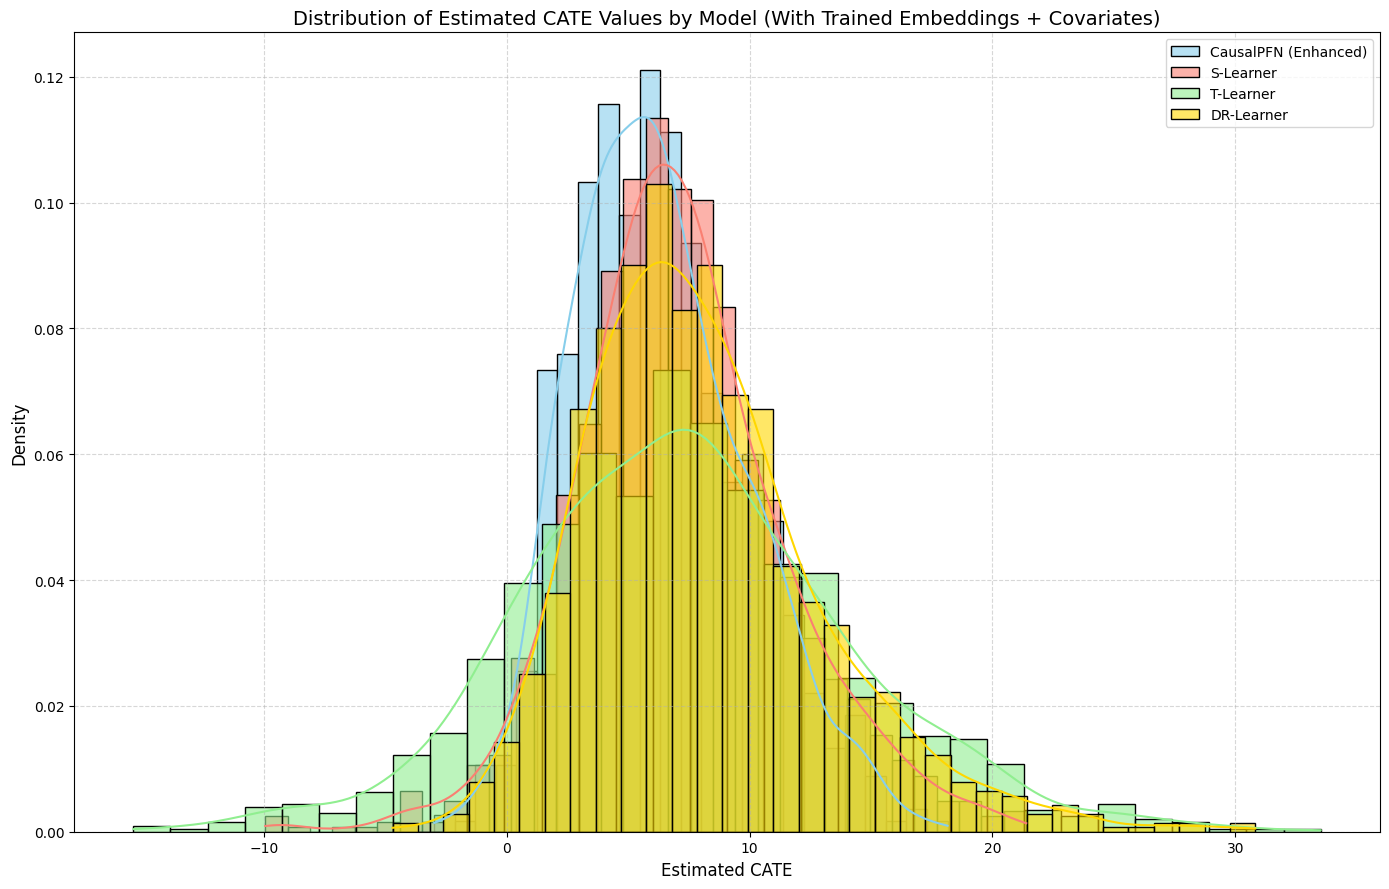

In [ ]:
# ============================================================================
# Visualization
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 9))

sns.histplot(cate_pfn, color='skyblue', label='CausalPFN (Enhanced)', kde=True, stat='density', alpha=0.6)
sns.histplot(cate_s, color='salmon', label='S-Learner', kde=True, stat='density', alpha=0.6)
sns.histplot(cate_t, color='lightgreen', label='T-Learner', kde=True, stat='density', alpha=0.6)
sns.histplot(cate_dr, color='gold', label='DR-Learner', kde=True, stat='density', alpha=0.6)

if 'cate' in df.columns:
    sns.histplot(cate_true_test, color='red', label='True CATE', kde=True, stat='density', alpha=0.4, linestyle='--')

plt.title('Distribution of Estimated CATE Values by Model (With Trained Embeddings + Covariates)', fontsize=14)
plt.xlabel('Estimated CATE', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Additional comparison plot
if results_df is not None:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(results_df['Method'], results_df['PEHE'],
                   color=['skyblue', 'salmon', 'lightgreen', 'gold'])
    plt.title('PEHE Comparison Across Methods', fontsize=14, fontweight='bold')
    plt.xlabel('Method', fontsize=12)
    plt.ylabel('PEHE (Lower is Better)', fontsize=12)
    plt.xticks(rotation=15, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

Extra eval----  didnt checked it

In [ ]:
# ============================================================================
# Evaluation
# ============================================================================

has_ground_truth = 'cate' in df.columns

if has_ground_truth:
    cate_true = df['cate'].values
    _, idx_test = train_test_split(np.arange(len(df)), test_size=0.2, random_state=42)
    cate_true_test = cate_true[idx_test]

    def compute_pehe(pred, true):
        return np.sqrt(np.mean((pred - true)**2))

    pehe_pfn = compute_pehe(cate_pfn, cate_true_test)
    pehe_s = compute_pehe(cate_s, cate_true_test)
    pehe_t = compute_pehe(cate_t, cate_true_test)
    pehe_dr = compute_pehe(cate_dr, cate_true_test)

    results = {
        "Method": ["CausalPFN (Enhanced)", "S-Learner", "T-Learner", "DR-Learner"],
        "PEHE": [pehe_pfn, pehe_s, pehe_t, pehe_dr]
    }
    results_df = pd.DataFrame(results)
    print("\n" + "="*50)
    print("RESULTS - PEHE (Lower is Better)")
    print("="*50)
    display(results_df)
else:
    print("\n" + "="*50)
    print("⚠️  Ground truth CATE not available")
    print("="*50)
    print("Computing alternative evaluation metrics...")

    # Alternative metrics without ground truth
    from sklearn.metrics import mean_squared_error

    # Use observed outcomes to compute prediction quality
    # For treated units: Y_i under treatment
    # For control units: Y_i under control

    treated_mask_test = T_test == 1
    control_mask_test = T_test == 0

    # Compute MSE for outcome predictions
    mu1_pfn_pred = Y_test.copy()  # We'll need to get these from the model
    mu0_pfn_pred = Y_test.copy()

    # Calculate correlation between methods (model agreement)
    from scipy.stats import spearmanr, pearsonr

    corr_pfn_s = pearsonr(cate_pfn, cate_s)[0]
    corr_pfn_t = pearsonr(cate_pfn, cate_t)[0]
    corr_pfn_dr = pearsonr(cate_pfn, cate_dr)[0]
    corr_s_t = pearsonr(cate_s, cate_t)[0]

    results = {
        "Comparison": ["PFN vs S-Learner", "PFN vs T-Learner", "PFN vs DR-Learner", "S vs T-Learner"],
        "Correlation": [corr_pfn_s, corr_pfn_t, corr_pfn_dr, corr_s_t]
    }
    results_df = pd.DataFrame(results)
    print("\n📊 Model Agreement (Correlation of CATE predictions):")
    display(results_df.round(4))

    # Compute variance and range of estimates
    variance_stats = {
        "Method": ["CausalPFN", "S-Learner", "T-Learner", "DR-Learner"],
        "Mean CATE": [cate_pfn.mean(), cate_s.mean(), cate_t.mean(), cate_dr.mean()],
        "Std CATE": [cate_pfn.std(), cate_s.std(), cate_t.std(), cate_dr.std()],
        "Range": [cate_pfn.max()-cate_pfn.min(), cate_s.max()-cate_s.min(),
                  cate_t.max()-cate_t.min(), cate_dr.max()-cate_dr.min()]
    }
    variance_df = pd.DataFrame(variance_stats)
    print("\n📈 CATE Estimate Statistics:")
    display(variance_df.round(4))

    cate_true_test = None  # Set to None for visualization logic



⚠️  Ground truth CATE not available
Computing alternative evaluation metrics...

📊 Model Agreement (Correlation of CATE predictions):


,Comparison,Correlation
0,PFN vs S-Learner,0.5222
1,PFN vs T-Learner,0.5382
2,PFN vs DR-Learner,0.6806
3,S vs T-Learner,0.5632



📈 CATE Estimate Statistics:


,Method,Mean CATE,Std CATE,Range
0,CausalPFN,6.2889,3.5045,21.1404
1,S-Learner,7.1376,4.2761,31.3394
2,T-Learner,7.2747,6.7242,48.8940
3,DR-Learner,8.1119,4.8983,35.5266


/tmp/ipython-input-380396014.py:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=list(data_for_box.keys()), patch_artist=True,


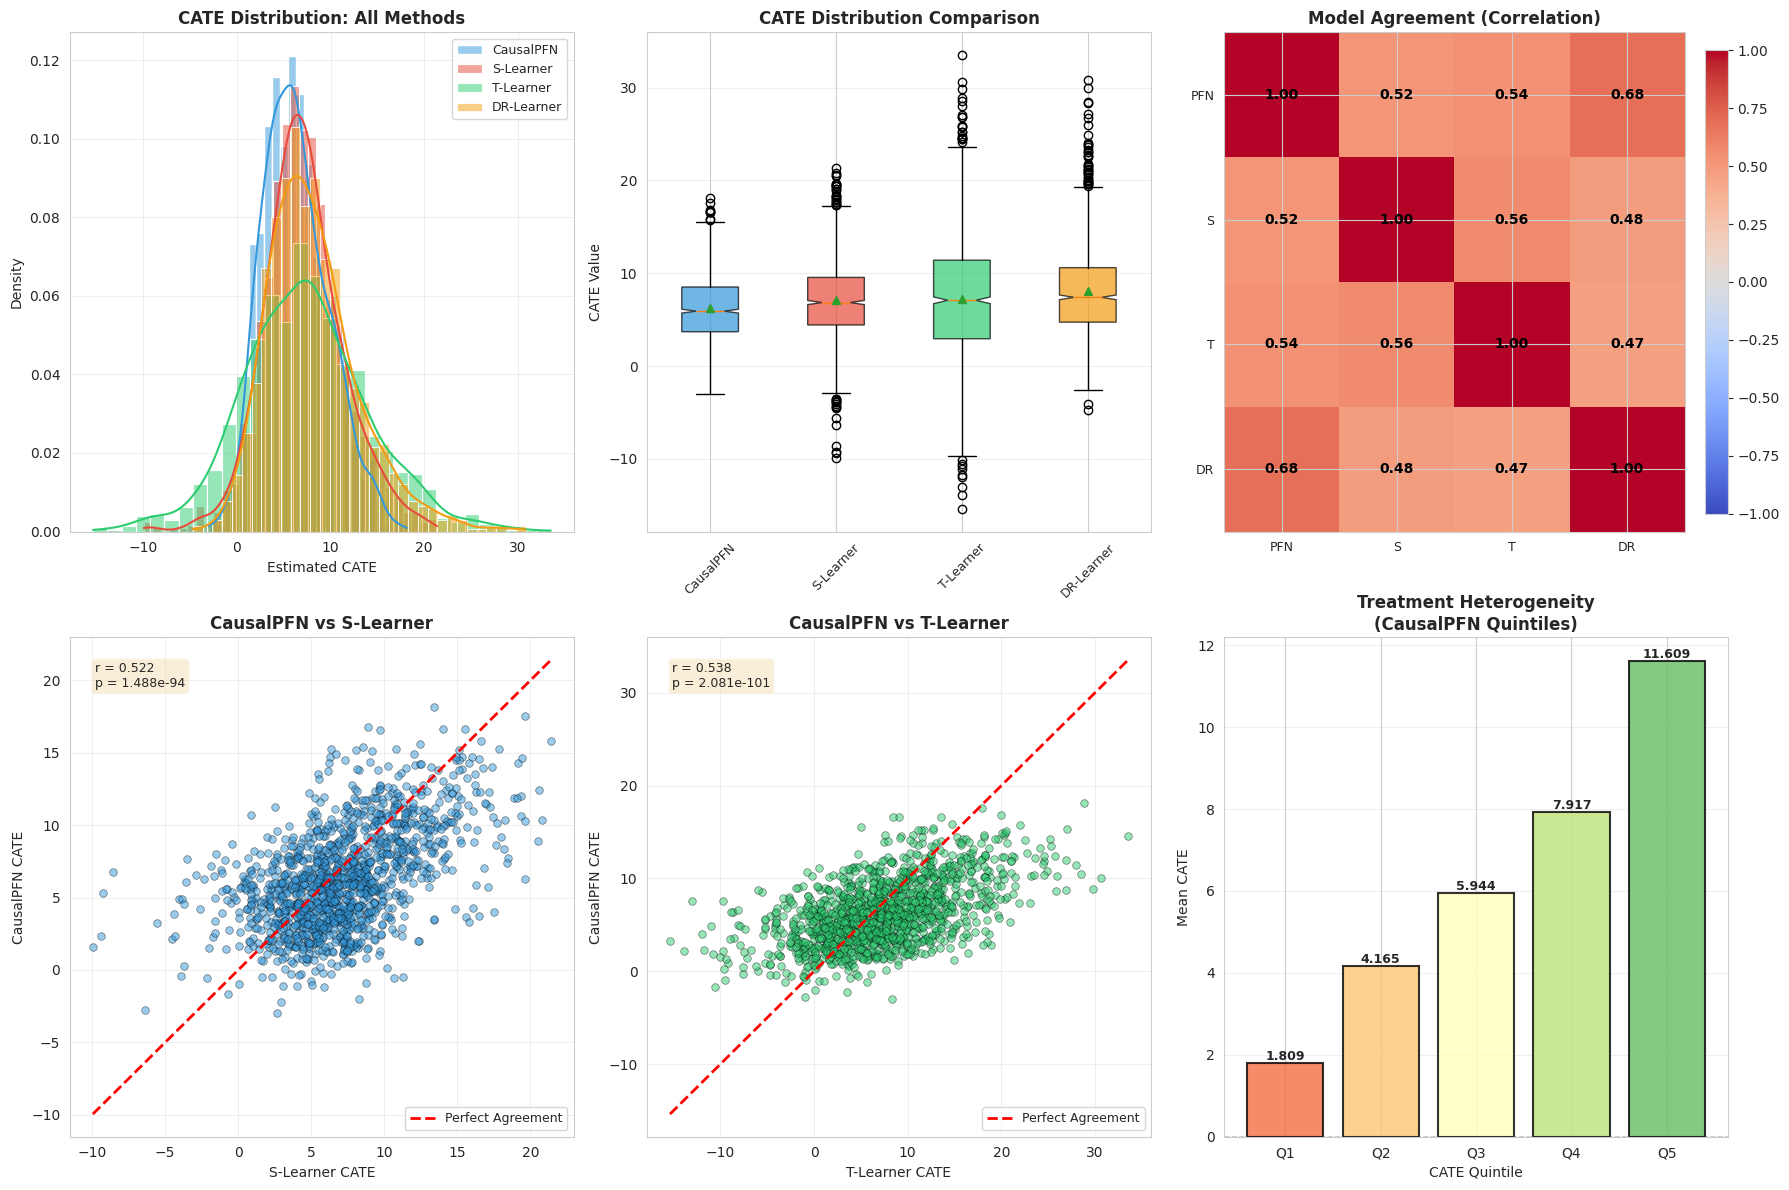


📊 Comprehensive visualization saved to: /content/cate_comprehensive_results.png


In [ ]:
# ============================================================================
# Visualization
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Create a comprehensive visualization
if has_ground_truth:
    # WITH GROUND TRUTH - 6 panel layout
    fig = plt.figure(figsize=(18, 12))

    # Panels 1-3: Individual distributions with true CATE
    ax1 = plt.subplot(2, 3, 1)
    sns.histplot(cate_pfn, color='#3498db', label='CausalPFN', kde=True, stat='density', alpha=0.7, ax=ax1)
    sns.histplot(cate_true_test, color='red', label='True CATE', kde=True, stat='density', alpha=0.3, ax=ax1, linestyle='--')
    ax1.set_title('CausalPFN (Enhanced)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('CATE', fontsize=10)
    ax1.set_ylabel('Density', fontsize=10)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(2, 3, 2)
    sns.histplot(cate_s, color='#e74c3c', label='S-Learner', kde=True, stat='density', alpha=0.7, ax=ax2)
    sns.histplot(cate_true_test, color='red', label='True CATE', kde=True, stat='density', alpha=0.3, ax=ax2, linestyle='--')
    ax2.set_title('S-Learner', fontsize=12, fontweight='bold')
    ax2.set_xlabel('CATE', fontsize=10)
    ax2.set_ylabel('Density', fontsize=10)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(2, 3, 3)
    sns.histplot(cate_t, color='#2ecc71', label='T-Learner', kde=True, stat='density', alpha=0.7, ax=ax3)
    sns.histplot(cate_true_test, color='red', label='True CATE', kde=True, stat='density', alpha=0.3, ax=ax3, linestyle='--')
    ax3.set_title('T-Learner', fontsize=12, fontweight='bold')
    ax3.set_xlabel('CATE', fontsize=10)
    ax3.set_ylabel('Density', fontsize=10)
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # Panel 4: PEHE comparison
    ax4 = plt.subplot(2, 3, 4)
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    bars = ax4.bar(results_df['Method'], results_df['PEHE'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax4.set_title('PEHE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Method', fontsize=10)
    ax4.set_ylabel('PEHE', fontsize=10)
    ax4.tick_params(axis='x', rotation=45, labelsize=9)
    ax4.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Panel 5: Predicted vs True CATE
    ax5 = plt.subplot(2, 3, 5)
    ax5.scatter(cate_true_test, cate_pfn, alpha=0.5, s=30, c='#3498db', label='CausalPFN', edgecolors='black', linewidth=0.5)
    min_val = min(cate_true_test.min(), cate_pfn.min())
    max_val = max(cate_true_test.max(), cate_pfn.max())
    ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax5.set_title('CausalPFN: Predicted vs True CATE', fontsize=12, fontweight='bold')
    ax5.set_xlabel('True CATE', fontsize=10)
    ax5.set_ylabel('Predicted CATE', fontsize=10)
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    from sklearn.metrics import r2_score
    r2 = r2_score(cate_true_test, cate_pfn)
    ax5.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax5.transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Panel 6: Box plot
    ax6 = plt.subplot(2, 3, 6)
    data_for_box = {
        'CausalPFN': cate_pfn,
        'S-Learner': cate_s,
        'T-Learner': cate_t,
        'DR-Learner': cate_dr,
        'True CATE': cate_true_test
    }
    box_data = [data_for_box[key] for key in data_for_box.keys()]
    bp = ax6.boxplot(box_data, labels=list(data_for_box.keys()), patch_artist=True,
                     notch=True, showmeans=True)

    colors_box = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#e91e63']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax6.set_title('CATE Distribution Comparison', fontsize=12, fontweight='bold')
    ax6.set_ylabel('CATE Value', fontsize=10)
    ax6.tick_params(axis='x', rotation=45, labelsize=9)
    ax6.grid(True, axis='y', alpha=0.3)

else:
    # WITHOUT GROUND TRUTH - Alternative visualization
    fig = plt.figure(figsize=(18, 12))

    # Panel 1: All distributions overlaid
    ax1 = plt.subplot(2, 3, 1)
    sns.histplot(cate_pfn, color='#3498db', label='CausalPFN', kde=True, stat='density', alpha=0.5, ax=ax1)
    sns.histplot(cate_s, color='#e74c3c', label='S-Learner', kde=True, stat='density', alpha=0.5, ax=ax1)
    sns.histplot(cate_t, color='#2ecc71', label='T-Learner', kde=True, stat='density', alpha=0.5, ax=ax1)
    sns.histplot(cate_dr, color='#f39c12', label='DR-Learner', kde=True, stat='density', alpha=0.5, ax=ax1)
    ax1.set_title('CATE Distribution: All Methods', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Estimated CATE', fontsize=10)
    ax1.set_ylabel('Density', fontsize=10)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Panel 2: Box plot comparison
    ax2 = plt.subplot(2, 3, 2)
    data_for_box = {
        'CausalPFN': cate_pfn,
        'S-Learner': cate_s,
        'T-Learner': cate_t,
        'DR-Learner': cate_dr
    }
    box_data = [data_for_box[key] for key in data_for_box.keys()]
    bp = ax2.boxplot(box_data, labels=list(data_for_box.keys()), patch_artist=True,
                     notch=True, showmeans=True)

    colors_box = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_title('CATE Distribution Comparison', fontsize=12, fontweight='bold')
    ax2.set_ylabel('CATE Value', fontsize=10)
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    ax2.grid(True, axis='y', alpha=0.3)

    # Panel 3: Correlation heatmap
    ax3 = plt.subplot(2, 3, 3)
    cate_estimates = np.column_stack([cate_pfn, cate_s, cate_t, cate_dr])
    corr_matrix = np.corrcoef(cate_estimates.T)
    im = ax3.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax3.set_xticks(range(4))
    ax3.set_yticks(range(4))
    ax3.set_xticklabels(['PFN', 'S', 'T', 'DR'], fontsize=9)
    ax3.set_yticklabels(['PFN', 'S', 'T', 'DR'], fontsize=9)
    ax3.set_title('Model Agreement (Correlation)', fontsize=12, fontweight='bold')

    # Add correlation values
    for i in range(4):
        for j in range(4):
            text = ax3.text(j, i, f'{corr_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=10, fontweight='bold')

    plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

    # Panel 4: Scatter - PFN vs S-Learner
    ax4 = plt.subplot(2, 3, 4)
    ax4.scatter(cate_s, cate_pfn, alpha=0.5, s=30, c='#3498db', edgecolors='black', linewidth=0.5)
    min_val = min(cate_s.min(), cate_pfn.min())
    max_val = max(cate_s.max(), cate_pfn.max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Agreement')
    ax4.set_title('CausalPFN vs S-Learner', fontsize=12, fontweight='bold')
    ax4.set_xlabel('S-Learner CATE', fontsize=10)
    ax4.set_ylabel('CausalPFN CATE', fontsize=10)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    from scipy.stats import pearsonr
    r, p = pearsonr(cate_s, cate_pfn)
    ax4.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3e}', transform=ax4.transAxes,
             fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Panel 5: Scatter - PFN vs T-Learner
    ax5 = plt.subplot(2, 3, 5)
    ax5.scatter(cate_t, cate_pfn, alpha=0.5, s=30, c='#2ecc71', edgecolors='black', linewidth=0.5)
    min_val = min(cate_t.min(), cate_pfn.min())
    max_val = max(cate_t.max(), cate_pfn.max())
    ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Agreement')
    ax5.set_title('CausalPFN vs T-Learner', fontsize=12, fontweight='bold')
    ax5.set_xlabel('T-Learner CATE', fontsize=10)
    ax5.set_ylabel('CausalPFN CATE', fontsize=10)
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    r, p = pearsonr(cate_t, cate_pfn)
    ax5.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3e}', transform=ax5.transAxes,
             fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Panel 6: Treatment effect heterogeneity
    ax6 = plt.subplot(2, 3, 6)

    # Create bins based on predicted CATE (using CausalPFN)
    n_bins = 5
    cate_bins = pd.qcut(cate_pfn, q=n_bins, labels=[f'Q{i+1}' for i in range(n_bins)])

    # Calculate average treatment effect in each bin
    bin_effects = []
    bin_labels = []
    for bin_label in [f'Q{i+1}' for i in range(n_bins)]:
        mask = cate_bins == bin_label
        if mask.sum() > 0:
            bin_effects.append(cate_pfn[mask].mean())
            bin_labels.append(bin_label)

    colors_gradient = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(bin_effects)))
    bars = ax6.bar(bin_labels, bin_effects, color=colors_gradient, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax6.set_title('Treatment Heterogeneity\n(CausalPFN Quintiles)', fontsize=12, fontweight='bold')
    ax6.set_xlabel('CATE Quintile', fontsize=10)
    ax6.set_ylabel('Mean CATE', fontsize=10)
    ax6.grid(True, axis='y', alpha=0.3)
    ax6.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/cate_comprehensive_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("📊 Comprehensive visualization saved to: /content/cate_comprehensive_results.png")
print("="*70)



/tmp/ipython-input-2564776228.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_violin_melted, x='Method', y='CATE', ax=axes[0, 1],


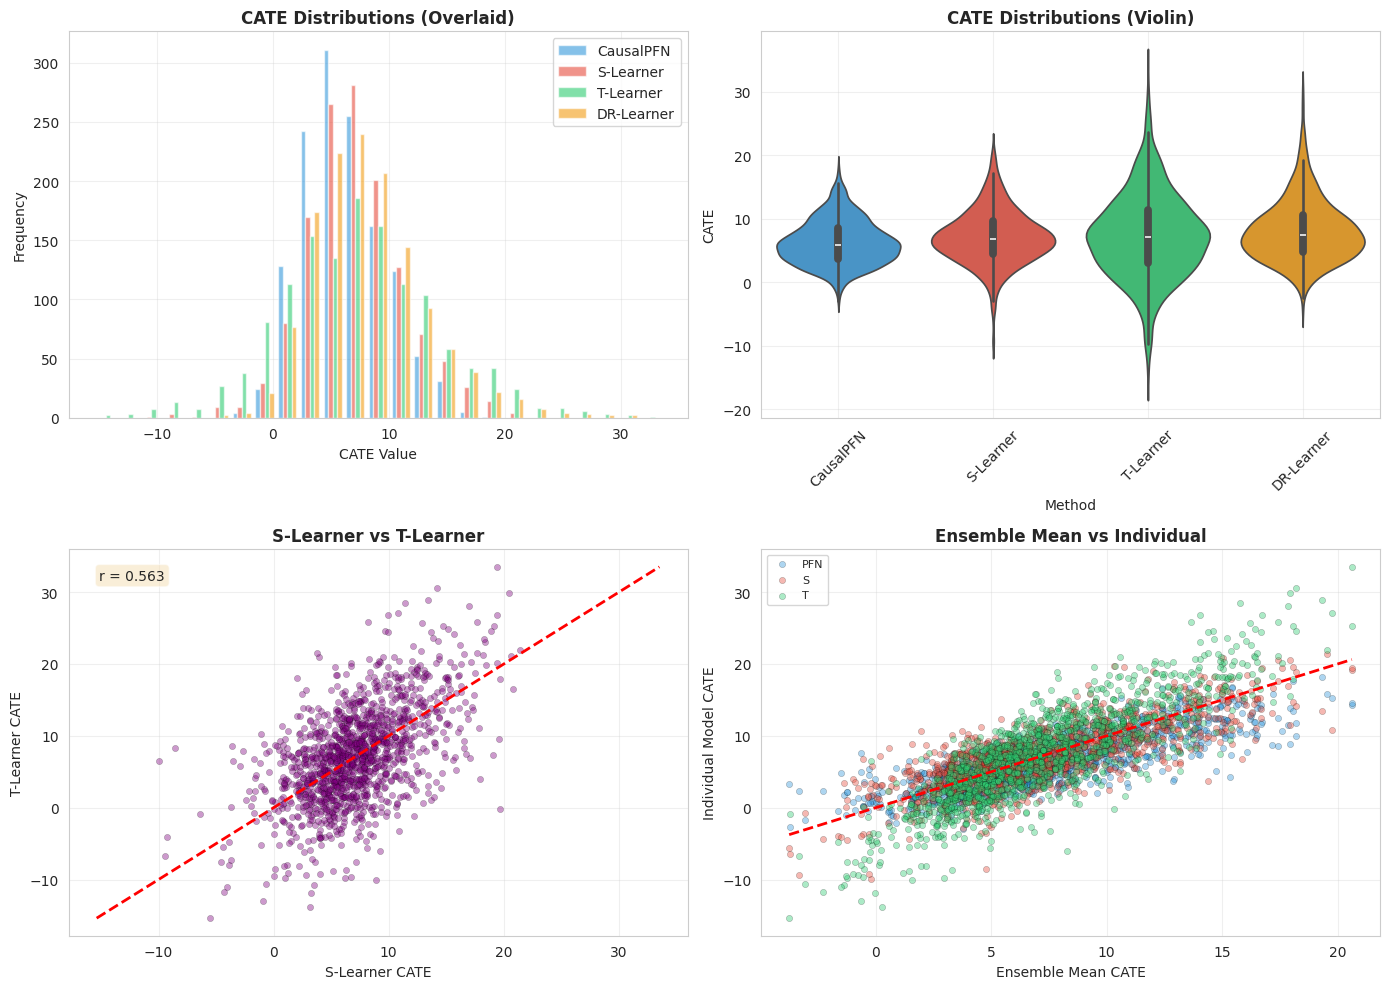

📊 Diagnostic plots saved to: /content/cate_diagnostic_plots.png


In [ ]:
# ============================================================================
# Additional Diagnostic Plots
# ============================================================================

if has_ground_truth:
    # Residual Analysis (only available with ground truth)
    fig2, axes = plt.subplots(1, 3, figsize=(18, 5))

    residuals_pfn = cate_pfn - cate_true_test
    residuals_s = cate_s - cate_true_test
    residuals_t = cate_t - cate_true_test

    # Plot 1: Residual Distribution
    axes[0].hist(residuals_pfn, bins=30, alpha=0.7, color='#3498db', label='CausalPFN', edgecolor='black')
    axes[0].hist(residuals_s, bins=30, alpha=0.5, color='#e74c3c', label='S-Learner', edgecolor='black')
    axes[0].hist(residuals_t, bins=30, alpha=0.5, color='#2ecc71', label='T-Learner', edgecolor='black')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0].set_title('Residual Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Residual (Predicted - True)', fontsize=10)
    axes[0].set_ylabel('Frequency', fontsize=10)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Residuals vs True CATE
    axes[1].scatter(cate_true_test, residuals_pfn, alpha=0.5, s=30, c='#3498db', edgecolors='black', linewidth=0.5)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Residual Plot (CausalPFN)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('True CATE', fontsize=10)
    axes[1].set_ylabel('Residual', fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Q-Q Plot
    stats.probplot(residuals_pfn, dist="norm", plot=axes[2])
    axes[2].set_title('Q-Q Plot (CausalPFN Residuals)', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/cate_residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("📊 Residual analysis saved to: /content/cate_residual_analysis.png")

else:
    # Alternative diagnostics without ground truth
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Individual method distributions
    axes[0, 0].hist([cate_pfn, cate_s, cate_t, cate_dr], bins=25, alpha=0.6,
                    label=['CausalPFN', 'S-Learner', 'T-Learner', 'DR-Learner'],
                    color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
    axes[0, 0].set_title('CATE Distributions (Overlaid)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('CATE Value', fontsize=10)
    axes[0, 0].set_ylabel('Frequency', fontsize=10)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Violin plot
    data_violin = pd.DataFrame({
        'CausalPFN': cate_pfn,
        'S-Learner': cate_s,
        'T-Learner': cate_t,
        'DR-Learner': cate_dr
    })
    data_violin_melted = data_violin.melt(var_name='Method', value_name='CATE')
    sns.violinplot(data=data_violin_melted, x='Method', y='CATE', ax=axes[0, 1],
                   palette=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
    axes[0, 1].set_title('CATE Distributions (Violin)', fontsize=12, fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Pairwise scatter - S vs T
    axes[1, 0].scatter(cate_s, cate_t, alpha=0.4, s=20, c='purple', edgecolors='black', linewidth=0.3)
    min_val = min(cate_s.min(), cate_t.min())
    max_val = max(cate_s.max(), cate_t.max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    axes[1, 0].set_title('S-Learner vs T-Learner', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('S-Learner CATE', fontsize=10)
    axes[1, 0].set_ylabel('T-Learner CATE', fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    r_st, _ = pearsonr(cate_s, cate_t)
    axes[1, 0].text(0.05, 0.95, f'r = {r_st:.3f}', transform=axes[1, 0].transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Plot 4: Ensemble mean vs individual predictions
    cate_ensemble_mean = (cate_pfn + cate_s + cate_t + cate_dr) / 4
    axes[1, 1].scatter(cate_ensemble_mean, cate_pfn, alpha=0.4, s=20, c='#3498db', label='PFN', edgecolors='black', linewidth=0.3)
    axes[1, 1].scatter(cate_ensemble_mean, cate_s, alpha=0.4, s=20, c='#e74c3c', label='S', edgecolors='black', linewidth=0.3)
    axes[1, 1].scatter(cate_ensemble_mean, cate_t, alpha=0.4, s=20, c='#2ecc71', label='T', edgecolors='black', linewidth=0.3)
    min_val = min(cate_ensemble_mean.min(), cate_pfn.min())
    max_val = max(cate_ensemble_mean.max(), cate_pfn.max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    axes[1, 1].set_title('Ensemble Mean vs Individual', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Ensemble Mean CATE', fontsize=10)
    axes[1, 1].set_ylabel('Individual Model CATE', fontsize=10)
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/cate_diagnostic_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("📊 Diagnostic plots saved to: /content/cate_diagnostic_plots.png")
